In [1]:
from pySnowRadar.processing import geo_filter, batch_process
from glob import glob
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pySnowRadar.qc import error_check
from pySnowRadar import SnowRadar
from pySnowRadar.processing import extract_layers, geo_filter, calc_snr
from pySnowRadar.geofunc import haversine

import geopandas as gpd
from shapely.geometry import Point, Polygon

In [2]:
def plot_retreival(sr, res, ylim=None):
    '''
    Generic plotting function to visualize the radar data for the 
    current SnowRadar object instance

    Arguments:
        ylim: customize the upper bound of the plot
    '''
    with np.errstate(divide='ignore', invalid='ignore'):
            radar_sub = 10 * np.log10(sr.data_radar)
            
    fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(9,7), sharex=True)
    #fig, ax = plt.subplots(figsize=(9,7))
    im = ax1.imshow(radar_sub, cmap='gist_gray')
    
    ax1.scatter(res.index.astype(int), 
                res['b_ref'] + res['b_as'], 
                color='b',
                s = 1,
                label = 'A-S')
    
    ax1.scatter(res.index.astype(int), 
                res['b_ref'] + res['b_si'], 
                color='r',
                s = 1,
                label = 'S-I')
    
    ax1.set_title(
        f'{sr.file_name} ({sr.data_type})',
        fontdict={'size':'x-large'}
        )
    if ylim:
        ax1.set_ylim(ylim)
    
    ax1.set_xlim(0, sr.data_radar.shape[1])
    ax1.set_aspect('auto')
    
    ax2.scatter(res.index.astype(int), 
                res.snow_depth,
                s = 1,
                color = 'k')
    
    #fig.colorbar(im, ax=ax1)
    fig.tight_layout()
    plt.show()

(array([3.0428e+04, 1.9030e+04, 3.2140e+03, 9.5300e+02, 3.2000e+02,
        1.1800e+02, 4.7000e+01, 4.0000e+00, 4.0000e+00, 7.0000e+00]),
 array([-1.0000e-01,  1.9910e+01,  3.9920e+01,  5.9930e+01,  7.9940e+01,
         9.9950e+01,  1.1996e+02,  1.3997e+02,  1.5998e+02,  1.7999e+02,
         2.0000e+02]),
 <a list of 10 Patch objects>)

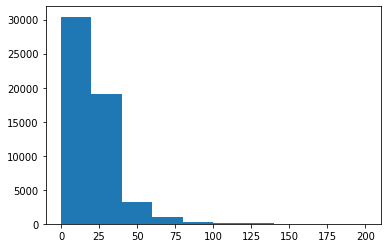

In [3]:
# Load the reference snow data for Eureka
mp_df = pd.read_csv('../pySnowRadar/data/field/eureka_2016_mp.csv')
mp_df.head()
mp_df['geometry'] = mp_df.apply(lambda row: Point(row.Longitude, row.Latitude), axis=1)

mp_gdf = gpd.GeoDataFrame(mp_df, geometry=mp_df.geometry)
mp_gdf.crs = {'init' :'epsg:4326'}
mp_gdf = mp_gdf.to_crs({'init':'epsg:32616'})

plt.hist(mp_gdf.DepthCm)

In [4]:
# Load the SR meta data into a dataframe
input_sr_data = glob('../pySnowRadar/data/sr/20160419_04/*.mat')
sr_meta = [SnowRadar(sr, 'meta') for sr in input_sr_data]
sr_gdf = gpd.GeoDataFrame(
        data={'file': [sr.file_path for sr in sr_meta]}, 
        geometry=[sr.line for sr in sr_meta], 
        crs={'init': 'epsg:4326'}
    )

# Create a 15 m buffer geometry around each SR point
sr_gdf = sr_gdf.to_crs({'init':'epsg:32616'})
sr_gdf['geometry'] = sr_gdf.buffer(15)

Loading: Data_20160419_04_001.mat (meta)
Loading: Data_20160419_04_002.mat (meta)
Loading: Data_20160419_04_003.mat (meta)
Loading: Data_20160419_04_004.mat (meta)
Loading: Data_20160419_04_005.mat (meta)
Loading: Data_20160419_04_006.mat (meta)
Loading: Data_20160419_04_007.mat (meta)
Loading: Data_20160419_04_008.mat (meta)
Loading: Data_20160419_04_009.mat (meta)
Loading: Data_20160419_04_010.mat (meta)
Loading: Data_20160419_04_011.mat (meta)
Loading: Data_20160419_04_012.mat (meta)
Loading: Data_20160419_04_013.mat (meta)
Loading: Data_20160419_04_014.mat (meta)
Loading: Data_20160419_04_015.mat (meta)
Loading: Data_20160419_04_016.mat (meta)
Loading: Data_20160419_04_017.mat (meta)
Loading: Data_20160419_04_018.mat (meta)
Loading: Data_20160419_04_019.mat (meta)
Loading: Data_20160419_04_020.mat (meta)
Loading: Data_20160419_04_021.mat (meta)
Loading: Data_20160419_04_022.mat (meta)
Loading: Data_20160419_04_023.mat (meta)
Loading: Data_20160419_04_024.mat (meta)
Loading: Data_20

Loading: Data_20160419_04_239.mat (meta)
Loading: Data_20160419_04_240.mat (meta)
Loading: Data_20160419_04_241.mat (meta)
Loading: Data_20160419_04_242.mat (meta)
Loading: Data_20160419_04_243.mat (meta)
Loading: Data_20160419_04_244.mat (meta)
Loading: Data_20160419_04_245.mat (meta)
Loading: Data_20160419_04_246.mat (meta)
Loading: Data_20160419_04_247.mat (meta)
Loading: Data_20160419_04_248.mat (meta)
Loading: Data_20160419_04_249.mat (meta)
Loading: Data_20160419_04_250.mat (meta)
Loading: Data_20160419_04_251.mat (meta)
Loading: Data_20160419_04_252.mat (meta)
Loading: Data_20160419_04_253.mat (meta)
Loading: Data_20160419_04_254.mat (meta)
Loading: Data_20160419_04_255.mat (meta)
Loading: Data_20160419_04_256.mat (meta)
Loading: Data_20160419_04_257.mat (meta)
Loading: Data_20160419_04_258.mat (meta)
Loading: Data_20160419_04_259.mat (meta)
Loading: Data_20160419_04_260.mat (meta)
Loading: Data_20160419_04_261.mat (meta)
Loading: Data_20160419_04_262.mat (meta)
Loading: Data_20

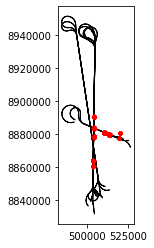

In [5]:
# Plot the data together
flight_lines = sr_gdf.plot(color='black', edgecolor='black', label = 'SnowRadar')
mp_gdf.plot(ax=flight_lines, marker='o', color='red', markersize=5, label = 'In-situ')


In [6]:
# Intersect the two data sources to see where we have validation data available
# then cut down the dataset to just SR frames with ground data

insitu_intersect = gpd.sjoin(sr_gdf, mp_gdf, how='inner', op='intersects')
insitu_filtered = insitu_intersect.file.unique()
geo_filtered = geo_filter(insitu_filtered)

# Generate error codes for remaining SR data
sr_data = [SnowRadar(sr, 'full') for sr in geo_filtered]
error_codes = [pd.Series(error_check(sr).tolist()) for sr in sr_data]

Loading: Data_20160419_04_001.mat (meta)
Loading: Data_20160419_04_083.mat (meta)
Loading: Data_20160419_04_177.mat (meta)
Loading: Data_20160419_04_034.mat (meta)
Loading: Data_20160419_04_048.mat (meta)
Loading: Data_20160419_04_211.mat (meta)
Loading: Data_20160419_04_227.mat (meta)
Loading: Data_20160419_04_047.mat (meta)
Loading: Data_20160419_04_035.mat (meta)
Loading: Data_20160419_04_004.mat (meta)
Loading: Data_20160419_04_032.mat (meta)
Loading: Data_20160419_04_050.mat (meta)
Loading: Data_20160419_04_080.mat (meta)
Loading: Data_20160419_04_180.mat (meta)
Loading: Data_20160419_04_208.mat (meta)
Loading: Data_20160419_04_230.mat (meta)
Loading: Data_20160419_04_259.mat (meta)
Loading: Data_20160419_04_005.mat (meta)
Loading: Data_20160419_04_031.mat (meta)
Loading: Data_20160419_04_051.mat (meta)
Loading: Data_20160419_04_181.mat (meta)
Loading: Data_20160419_04_207.mat (meta)
Loading: Data_20160419_04_231.mat (meta)
Loading: Data_20160419_04_079.mat (meta)
Loading: Data_20

In [7]:
cur_file = geo_filtered[1]
snow_density = 0.3
r_idx = np.sqrt((1 + 0.51 * snow_density) ** 3)
radar_dat = SnowRadar(cur_file, 'full')
radar_dat.surf_bin, radar_dat.surface = radar_dat.get_surface()
radar_dat.calcpulsewidth()
lower, upper = radar_dat.get_bounds(m_above=5)
radar_subset = radar_dat.data_radar[upper:lower, :]


Loading: Data_20160419_04_083.mat (full)


In [8]:
#from pySnowRadar.algorithms import GSFC_NK, NSIDC, Wavelet_TN, Wavelet_JK

In [9]:
#picker_list = pySnowRadar.algorithms.available_pickers()
#picker=pySnowRadar.algorithms.Wavelet_TN
#picker in picker_list

In [11]:
import pySnowRadar.algorithms
params={'snow_density':0.3,
        'ref_snow_layer': 1,
        'cwt_precision': 10}

UsageError: Line magic function `%%time` not found.


In [13]:
%%time
res = extract_layers(cur_file, picker=pySnowRadar.algorithms.Wavelet_JK, params=params, dump_results=False)

Loading: Data_20160419_04_083.mat (full)
Wall time: 3.25 s


In [14]:
%%time
res_tn = extract_layers(cur_file, picker=pySnowRadar.algorithms.Wavelet_TN, params=params, dump_results=False)

Loading: Data_20160419_04_083.mat (full)
Wall time: 20.1 s


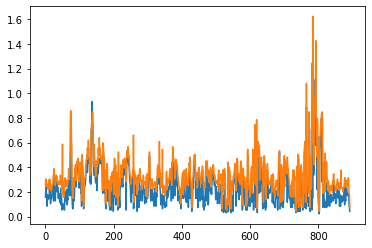

In [16]:
plt.plot(res.snow_depth)
plt.plot(res_tn.snow_depth)

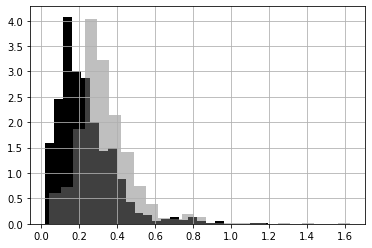

In [21]:
res.snow_depth.hist(density = True, color = 'k', bins = 25)
res_tn.snow_depth.hist(density = True, color = 'grey', bins = 25, alpha = 0.5)

## Batch testing

In [90]:
from concurrent.futures import ProcessPoolExecutor
from multiprocessing import cpu_count

workers = 4
input_sr_data = geo_filtered[0:2]
dump_results=False
picker=pySnowRadar.algorithms.Wavelet_JK

params={'snow_density':0.3,
        'ref_snow_layer': 1,
        'cwt_precision': 10}

if 'snow_density' not in params:
        raise ValueError(
            'Snow density or refractive index input required for all pickers'
        )

current_cores = cpu_count()
if workers > current_cores:
    raise SystemError('workers argument (passed: %d) cannot ' % workers + 
                      'exceed current CPU count (%d)' % current_cores)
    
    
length = len(input_sr_data)
dump_triggers = [dump_results] * length     
picker_args = [picker] * length                     
# Single value passed for snow_density
if isinstance(params['snow_density'], float):
    if not(0.1 <= snow_density <= 0.4):
        raise ValueError('Invalid snow density passed: %.3f ' % snow_density + \
                        '(Must be between 0.1 and 0.4)')
    else:
        process_args = zip(
            input_sr_data, 
            [picker] * length,
            [params] * length,
            dump_triggers
        )
#x = [foo for foo in process_args]
with ProcessPoolExecutor(workers) as pool:
     futures = [pool.submit(extract_layers, *foo) for foo in process_args]
     results = [f.result() for f in futures]
 # return a concatenated dataframe containing results for all input datasets
df = pd.concat(results)

0.16968101377614947

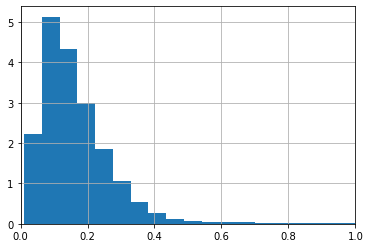

In [87]:
fig, ax = plt.subplots()
df.snow_depth.hist(ax=ax, density = True, bins = 50)
ax.set_xlim(0,1)
df.snow_depth.mean()

# Batch testing

In [126]:
workers = 6
input_sr_data = geo_filtered
dump_results=False
picker=pySnowRadar.algorithms.Wavelet_JK

Wall time: 0 ns


In [129]:
%%time
res = batch_process(input_sr_data, picker, params)

Wall time: 1min 17s


In [ ]:
res.snow_depth.hist(density = True)